---
title: "Part II: Motion processing"
authors: Gillian Rosenberg, Šárka Kadavá
---

We performed motion tracking with MediaPipe and now we have saved coordinates for each file in a csv file.

There are important things to do before we can actually start any analysis. But let's take it step by step

## Preparing an environment

In [3]:
import os
import glob
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# Get the current working directory
curfolder = os.getcwd()

mtfolder = os.path.join(curfolder, 'Output_TimeSeries')  # Folder containing motion-tracking CSV files
vidfolder = os.path.join(curfolder, 'ToTrack')      # Folder containing input

# Get all the files in the folder
mtfiles = glob.glob(os.path.join(mtfolder, '*body_world.csv'))  # Use os.path.join for compatibility
print('Motion-tracking files found:')
print(mtfiles)

vidfiles = glob.glob(os.path.join(vidfolder, '*.avi'))
print('Video files found:')
print(vidfiles)

Motion-tracking files found:
['c:\\Users\\kadava\\Documents\\Github\\MotionTrackingPipeline_ProDiGe2025\\Output_TimeSeries\\0_1_pr_36_p0_snijden_gebaren_video_raw_cam2.avi_body_world.csv', 'c:\\Users\\kadava\\Documents\\Github\\MotionTrackingPipeline_ProDiGe2025\\Output_TimeSeries\\0_1_trial_34_p1_springen_combinatie_video_raw_cam2.avi_body_world.csv', 'c:\\Users\\kadava\\Documents\\Github\\MotionTrackingPipeline_ProDiGe2025\\Output_TimeSeries\\0_1_trial_43_p0_sterk_gebaren_video_raw_cam2.avi_body_world.csv', 'c:\\Users\\kadava\\Documents\\Github\\MotionTrackingPipeline_ProDiGe2025\\Output_TimeSeries\\0_1_trial_53_p1_vangen_gebaren_video_raw_cam2.avi_body_world.csv']
Video files found:
['c:\\Users\\kadava\\Documents\\Github\\MotionTrackingPipeline_ProDiGe2025\\ToTrack\\0_1_pr_36_p0_snijden_gebaren_video_raw_cam2.avi', 'c:\\Users\\kadava\\Documents\\Github\\MotionTrackingPipeline_ProDiGe2025\\ToTrack\\0_1_trial_34_p1_springen_combinatie_video_raw_cam2.avi', 'c:\\Users\\kadava\\Documents

## Inspecting a file

Let's start by inspecting one file.



In [4]:
# Load in one file
sample = pd.read_csv(mtfiles[0])
sample.head()

,time,X_NOSE,Y_NOSE,Z_NOSE,visibility_NOSE,X_LEFT_EYE_INNER,Y_LEFT_EYE_INNER,Z_LEFT_EYE_INNER,visibility_LEFT_EYE_INNER,X_LEFT_EYE,...,Z_RIGHT_HEEL,visibility_RIGHT_HEEL,X_LEFT_FOOT_INDEX,Y_LEFT_FOOT_INDEX,Z_LEFT_FOOT_INDEX,visibility_LEFT_FOOT_INDEX,X_RIGHT_FOOT_INDEX,Y_RIGHT_FOOT_INDEX,Z_RIGHT_FOOT_INDEX,visibility_RIGHT_FOOT_INDEX
0,0.000000,-0.026192,-0.534993,-0.495419,0.999996,-0.009919,-0.558611,-0.490912,0.999993,-0.008088,...,0.181595,0.728093,0.148700,0.828051,0.227418,0.973645,-0.072642,0.788951,0.083766,0.972129
1,16.666667,-0.028713,-0.530168,-0.513629,0.999996,-0.012280,-0.554279,-0.509890,0.999992,-0.010304,...,0.200661,0.736955,0.148771,0.813154,0.283157,0.973510,-0.072638,0.781423,0.101956,0.973096
2,33.333333,-0.030368,-0.527301,-0.521864,0.999996,-0.013747,-0.551645,-0.518211,0.999992,-0.011683,...,0.205663,0.743518,0.148750,0.807369,0.295368,0.973125,-0.072758,0.777691,0.106949,0.973777
3,50.000000,-0.031195,-0.526229,-0.523962,0.999996,-0.014708,-0.550721,-0.520192,0.999992,-0.012599,...,0.209882,0.747403,0.147944,0.803070,0.299687,0.972226,-0.073030,0.774718,0.112329,0.974033
4,66.666667,-0.031717,-0.524564,-0.526216,0.999995,-0.015312,-0.549166,-0.522504,0.999991,-0.013176,...,0.211331,0.750610,0.147168,0.800965,0.295513,0.971547,-0.073186,0.773152,0.113881,0.974287


> ### 💠 What kind of columns do we see?

> ### 🕒 In what time interval are we saving the coordinates? What is our sampling rate?

> ### 📐 What do x, y, z coordinates represent?

> ### 👁️ What is 'visibility'?

## Cleaning

When we familiarized ourselves with the data, we can start step by step cleaning it.

For example, let's say we don't need the visibility column. It might be useful for some specific cases, but for now, we can drop it.

In [5]:
# Drop visibility cols

sample = sample.drop(sample.columns[sample.columns.str.contains('visibility',case = False)],axis = 1)

Now we conventiently reduced the number of columns to 100.

In [6]:
sample.head(20)

,time,X_NOSE,Y_NOSE,Z_NOSE,X_LEFT_EYE_INNER,Y_LEFT_EYE_INNER,Z_LEFT_EYE_INNER,X_LEFT_EYE,Y_LEFT_EYE,Z_LEFT_EYE,...,Z_LEFT_HEEL,X_RIGHT_HEEL,Y_RIGHT_HEEL,Z_RIGHT_HEEL,X_LEFT_FOOT_INDEX,Y_LEFT_FOOT_INDEX,Z_LEFT_FOOT_INDEX,X_RIGHT_FOOT_INDEX,Y_RIGHT_FOOT_INDEX,Z_RIGHT_FOOT_INDEX
0,0.000000,-0.026192,-0.534993,-0.495419,-0.009919,-0.558611,-0.490912,-0.008088,-0.557291,-0.477974,...,0.291425,-0.082728,0.756861,0.181595,0.148700,0.828051,0.227418,-0.072642,0.788951,0.083766
1,16.666667,-0.028713,-0.530168,-0.513629,-0.012280,-0.554279,-0.509890,-0.010304,-0.552534,-0.496630,...,0.334649,-0.082786,0.749310,0.200661,0.148771,0.813154,0.283157,-0.072638,0.781423,0.101956
2,33.333333,-0.030368,-0.527301,-0.521864,-0.013747,-0.551645,-0.518211,-0.011683,-0.549687,-0.504883,...,0.345725,-0.083036,0.745986,0.205663,0.148750,0.807369,0.295368,-0.072758,0.777691,0.106949
3,50.000000,-0.031195,-0.526229,-0.523962,-0.014708,-0.550721,-0.520192,-0.012599,-0.548703,-0.506855,...,0.348801,-0.083240,0.742878,0.209882,0.147944,0.803070,0.299687,-0.073030,0.774718,0.112329
4,66.666667,-0.031717,-0.524564,-0.526216,-0.015312,-0.549166,-0.522504,-0.013176,-0.547098,-0.509156,...,0.345637,-0.083436,0.741322,0.211331,0.147168,0.800965,0.295513,-0.073186,0.773152,0.113881
5,83.333333,-0.031981,-0.523983,-0.527386,-0.015506,-0.548496,-0.523649,-0.013368,-0.546411,-0.510295,...,0.344847,-0.083648,0.741140,0.211871,0.147147,0.801443,0.293932,-0.073372,0.773050,0.114039
6,100.000000,-0.031967,-0.523735,-0.526942,-0.015500,-0.548294,-0.523088,-0.013362,-0.546210,-0.509751,...,0.346820,-0.083830,0.740794,0.212649,0.147052,0.801765,0.297058,-0.073694,0.772629,0.114994
7,116.666667,-0.031952,-0.523196,-0.527682,-0.015488,-0.547855,-0.523807,-0.013352,-0.545752,-0.510477,...,0.348723,-0.083837,0.740257,0.213755,0.147016,0.801452,0.299407,-0.073689,0.771896,0.115918
8,133.333333,-0.031919,-0.522488,-0.527773,-0.015478,-0.547298,-0.523908,-0.013342,-0.545182,-0.510593,...,0.350175,-0.083867,0.740320,0.213399,0.146956,0.801462,0.300814,-0.073697,0.771769,0.115363
9,150.000000,-0.031496,-0.522263,-0.527438,-0.015237,-0.547127,-0.523566,-0.013093,-0.545013,-0.510257,...,0.349171,-0.083810,0.740275,0.213084,0.147041,0.801624,0.299458,-0.073663,0.771427,0.115095


Now let's check how do coordinates look like, for example for right wrist

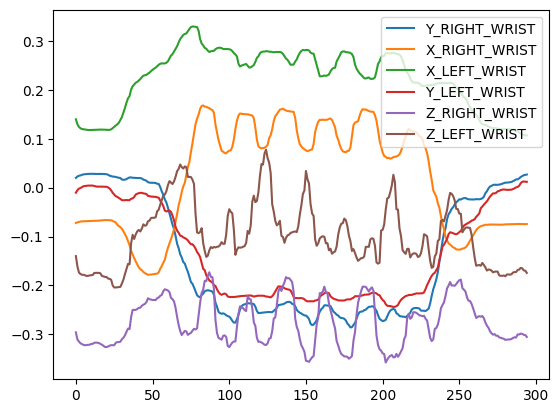

In [7]:
# Plot x, y, z for RIGHT_WRIST
sample['Y_RIGHT_WRIST'].plot()
sample['X_RIGHT_WRIST'].plot()
sample['X_LEFT_WRIST'].plot()
sample['Y_LEFT_WRIST'].plot()
sample['Z_RIGHT_WRIST'].plot()
sample['Z_LEFT_WRIST'].plot()
plt.legend()
plt.show()


Let's now check back to the video, so we can understand what do these coordinates represent.

In [16]:
import os, base64
from IPython.display import HTML


avi_path = vidfiles[0]        # path to your AVI file
mp4_path = "video_for_notebook.mp4"

# 1) Install ffmpeg in Colab if needed and convert to MP4
if not os.path.exists(mp4_path):
    try:
        import google.colab  # type: ignore
        !apt-get -y install ffmpeg
    except ImportError:
        pass

    !ffmpeg -i "$avi_path" -vcodec libx264 -acodec aac -strict experimental "$mp4_path"

# 2) Embed as HTML5 video (file-based, portable as long as you upload the mp4)
HTML(f"""
<video width="640" controls>
  <source src="{mp4_path}" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")


ffmpeg version n8.0-16-gd8605a6b55-20251008 Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 15.2.0 (crosstool-NG 1.28.0.1_403899e)
  configuration: --prefix=/ffbuild/prefix --pkg-config-flags=--static --pkg-config=pkg-config --cross-prefix=x86_64-w64-mingw32- --arch=x86_64 --target-os=mingw32 --enable-gpl --enable-version3 --disable-debug --disable-w32threads --enable-pthreads --enable-iconv --enable-zlib --enable-libxml2 --enable-libvmaf --enable-fontconfig --enable-libharfbuzz --enable-libfreetype --enable-libfribidi --enable-vulkan --enable-libshaderc --enable-libvorbis --disable-libxcb --disable-xlib --disable-libpulse --enable-opencl --enable-gmp --enable-lzma --enable-amf --enable-libaom --enable-libaribb24 --enable-avisynth --enable-chromaprint --enable-libdav1d --enable-libdavs2 --enable-libdvdread --enable-libdvdnav --disable-libfdk-aac --enable-ffnvcodec --enable-cuda-llvm --enable-frei0r --enable-libgme --enable-libkvazaar --enable-libaribcaption --enable-liba

> ### 👁️ What do we see? 

> ### 👁️ Does each axis agrees with how movement seem to be in the video?

> ### 👁️ Do you notice something weird?



- 
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-

>

Yes, there is indeed something weird.

First, notice that z-dimension indeed is quite noisy (or one might say even hallucinating). This is because depth estimation from a single camera is quite difficult, so MediaPipe is not very good at it.

Second, notice that y-dimension seems to be inverted. When the hand goes up, the y-coordinate decreases. 

# Flipping the data

In MediaPipe, for some reason the y-axis and z-axis are flipped. Who knows what is the reason, but for us this serves as a good example of why we **always** need to check our data.

In [8]:
# function to flip the data

def flip_data(df):
    cols = df.columns
    cols  = [col for col in df.columns if 'Y_' in col]
    cols = list(cols)
        # first get the vertical height of the configuration
        # we only do this for the first frame; the transformation will be applied to all frames
    maxpoint = []
    for joint in cols:
        maxpoint.append(df.loc[0, joint])
        # iterate over each joint, in each frame, to flip the y-axis
    for frame in range(len(df)):
        for joint in cols:
            ytrans = max(maxpoint) - df.loc[frame, joint] - 1
            df.loc[frame, joint] = ytrans
    return df

# use it on the file
sample = flip_data(sample)

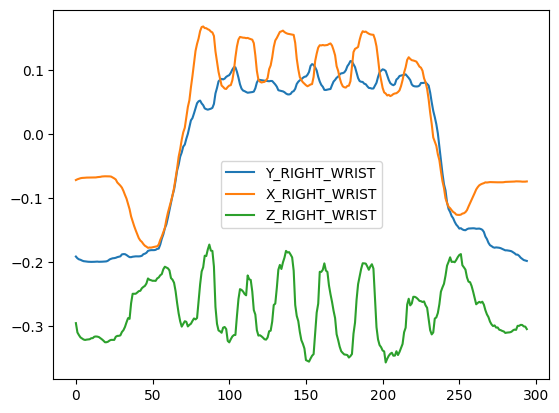

In [9]:
# plot to check
sample['Y_RIGHT_WRIST'].plot()
sample['X_RIGHT_WRIST'].plot()
sample['Z_RIGHT_WRIST'].plot()
plt.legend()
plt.show()

# Interpolating the data

This will be video-specific problem, but sometimes we might encounter that there are missing data points - for example, when one arm covers the other, or when arms cover the face, etc. If these missing windows are of reasonable length, we can **interpolate** them. Interpolation is a method that estimates a missing value based on the values of the surrounding data points.

In [10]:
# interpolate the data
def interpolate(sample):
    cols = sample.columns

    # put away time from cols
    cols = cols.drop(['time'])

    # loop over the cols and interpolate missing data
    for col in cols:
        sample[col] = sample[col].interpolate(method='linear', x = sample['time'], limit=10) # limit is the max number of missing values to fill
    
    return sample

# use it on the file
sample = interpolate(sample)


# Smoothing the data

Looking at the plots, you may notice that the data is quite noisy and jerky. This is because we are collecting each value for a keypoint at certain frame rate - for us it is ca. 16 ms. 

We can **smooth** the data with various filters - Butterworth, Savitzky-Golay, etc.

In this script, we will be using **Savitzky-Golay filter**. This filter fits a *x-order* polynomial to a sequence of data points and then evaluates the polynomial at the central point of the sequence. This is repeated for on sequence of *windows*. This allows us to smooth the data without losing the original shape of the curve.

When using this filter, we need to specify the *window* and *order* parameters. The *window* parameter specifies the number of data points used to fit the polynomial, while the *order* parameter specifies the order of the polynomial.

So now the question arises - HOW TO CHOOSE THOSE???

Once again, we are not going to blindly guess. We can just try different combinations and see which are smoothing the data approprietly, without losing too much of the original shape of the curve.

In [11]:
# function to check different smoothing windows and orders
def check_smooth_strength(df, windows, orders, keytoplot):

    # prepare new df
    df_smooth = pd.DataFrame()

    for win in windows:
        for ord in orders:
            df_smooth[keytoplot + '_savgol' + str(win) + '_' + str(ord)] = scipy.signal.savgol_filter(df[keytoplot], win, ord)

    # make R_Hand_x from df_sample a list
    keytoplot_unsmoothed = df[keytoplot].tolist()

    # load these values into df_smooth as a new column
    df_smooth[keytoplot] = keytoplot_unsmoothed

    # plot keytoplot in all strngths
    colstoplot = [x for x in df_smooth.columns if keytoplot in x]
    plt.figure()
    for col in colstoplot:
        plt.plot(df_smooth[col], label=col)
    plt.legend()
    plt.show()

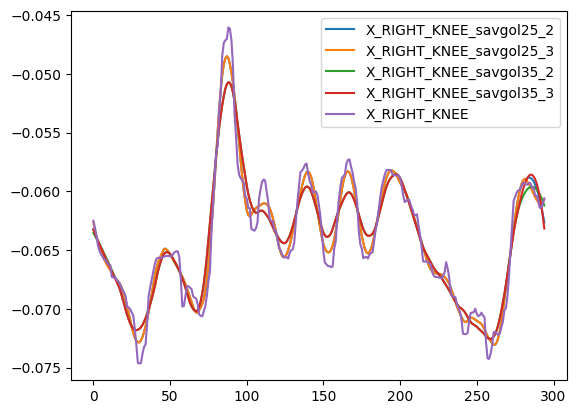

In [21]:
windows = [25, 35] # list possible window
orders = [2, 3] # list possible orders

check_smooth_strength(sample, windows, orders, 'X_RIGHT_KNEE')

> ### 🗫 Can you comment on some of the different combinations?

In [12]:
# smooth the data
def smooth_data(sample):
    cols_upperbody = ['X_NOSE', 'Y_NOSE', 'Z_NOSE', 'X_LEFT_EYE_INNER', 'Y_LEFT_EYE_INNER', 'Z_LEFT_EYE_INNER', 'X_LEFT_EYE', 'Y_LEFT_EYE', 'Z_LEFT_EYE', 'X_LEFT_EYE_OUTER', 'Y_LEFT_EYE_OUTER', 'Z_LEFT_EYE_OUTER', 'X_RIGHT_EYE_OUTER', 'Y_RIGHT_EYE_OUTER', 'Z_RIGHT_EYE_OUTER', 'X_RIGHT_EYE', 'Y_RIGHT_EYE', 'Z_RIGHT_EYE', 'X_RIGHT_EYE_OUTER.1', 'Y_RIGHT_EYE_OUTER.1', 'Z_RIGHT_EYE_OUTER.1', 'X_LEFT_EAR', 'Y_LEFT_EAR', 'Z_LEFT_EAR', 'X_RIGHT_EAR', 'Y_RIGHT_EAR', 'Z_RIGHT_EAR', 'X_MOUTH_LEFT', 'Y_MOUTH_LEFT', 'Z_MOUTH_LEFT', 'X_MOUTH_RIGHT', 'Y_MOUTH_RIGHT', 'Z_MOUTH_RIGHT', 'X_LEFT_SHOULDER', 'Y_LEFT_SHOULDER', 'Z_LEFT_SHOULDER', 'X_RIGHT_SHOULDER', 'Y_RIGHT_SHOULDER', 'Z_RIGHT_SHOULDER', 'X_LEFT_ELBOW', 'Y_LEFT_ELBOW', 'Z_LEFT_ELBOW', 'X_RIGHT_ELBOW', 'Y_RIGHT_ELBOW', 'Z_RIGHT_ELBOW', 'X_LEFT_WRIST', 'Y_LEFT_WRIST', 'Z_LEFT_WRIST', 'X_RIGHT_WRIST', 'Y_RIGHT_WRIST', 'Z_RIGHT_WRIST', 'X_LEFT_PINKY', 'Y_LEFT_PINKY', 'Z_LEFT_PINKY', 'X_RIGHT_PINKY', 'Y_RIGHT_PINKY', 'Z_RIGHT_PINKY', 'X_LEFT_INDEX', 'Y_LEFT_INDEX', 'Z_LEFT_INDEX', 'X_RIGHT_INDEX', 'Y_RIGHT_INDEX', 'Z_RIGHT_INDEX', 'X_LEFT_THUMB', 'Y_LEFT_THUMB', 'Z_LEFT_THUMB', 'X_RIGHT_THUMB', 'Y_RIGHT_THUMB']
    cols_lowerbody = ['X_LEFT_HIP',
       'Y_LEFT_HIP', 'Z_LEFT_HIP', 'X_RIGHT_HIP', 'Y_RIGHT_HIP', 'Z_RIGHT_HIP',
       'X_LEFT_KNEE', 'Y_LEFT_KNEE', 'Z_LEFT_KNEE', 'X_RIGHT_KNEE',
       'Y_RIGHT_KNEE', 'Z_RIGHT_KNEE', 'X_LEFT_ANKLE', 'Y_LEFT_ANKLE',
       'Z_LEFT_ANKLE', 'X_RIGHT_ANKLE', 'Y_RIGHT_ANKLE', 'Z_RIGHT_ANKLE',
       'X_LEFT_HEEL', 'Y_LEFT_HEEL', 'Z_LEFT_HEEL', 'X_RIGHT_HEEL',
       'Y_RIGHT_HEEL', 'Z_RIGHT_HEEL', 'X_LEFT_FOOT_INDEX',
       'Y_LEFT_FOOT_INDEX', 'Z_LEFT_FOOT_INDEX', 'X_RIGHT_FOOT_INDEX',
       'Y_RIGHT_FOOT_INDEX', 'Z_RIGHT_FOOT_INDEX']

# smooth upperbody and face with savgol 20,4
    for col in cols_upperbody:
        sample[col] = scipy.signal.savgol_filter(sample[col], 25, 3)

# smooth lowerbod with savgol 30,3
    for col in cols_lowerbody:  
        sample[col] = scipy.signal.savgol_filter(sample[col], 25, 3)
    return(sample)

# use it on the file
sample = smooth_data(sample)

# Getting derivatives

Now we are almost done! We have cleaned the data, interpolated it, smoothed it... and most likely, we want for analysis something more than just coordinates. 

Coordinates represent positional data. We can get more information from the data by calculating **the derivatives**. Derivatives represent the rate of change of a function at a given point.

First derivate of positional data represents the rate of change of the position. This means ....
Second derivate of positional data represents the rate of change of the rate of change of the position. This means ....
Third derivate of positional data represents the rate of change of the rate of change of the rate of change of the position. This means ....

Below, you can see functions that always have the same pipeline:
- collecting columns to be differentiated
- differentiating them
- smoothing the differentiated signal

In [13]:
import numpy as np
import pandas as pd
import scipy.signal


########################
# 3D SPEED
########################
def derive_speed_smooth(cols, sample, sr):
    # base marker names without X_/Y_/Z_
    speedcols = [c.replace('X_', '').replace('Y_', '').replace('Z_', '') for c in cols]
    speedcols = list(set(speedcols))

    new_speed = {}

    for col in speedcols:
        x = sample['X_' + col].to_numpy()
        y = sample['Y_' + col].to_numpy()
        z = sample['Z_' + col].to_numpy()

        # frame-to-frame 3D distance
        v = np.zeros_like(x, dtype=float)
        v[1:] = np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2)

        # convert to "per second" using sampling rate
        v *= sr

        # smooth (window length must be odd)
        v_smooth = scipy.signal.savgol_filter(v, 21, 4)

        new_speed[col + '_speed'] = v_smooth

    # add all speed columns at once
    speed_df = pd.DataFrame(new_speed, index=sample.index)
    sample = pd.concat([sample, speed_df], axis=1)

    return speedcols, sample


########################
# 2D SPEED
########################
def derive_2dspeed_smooth(cols, sample, sr):
    speedcols = [c.replace('X_', '').replace('Y_', '') for c in cols]
    speedcols = list(set(speedcols))

    new_speed2d = {}

    for col in speedcols:
        x = sample['X_' + col].to_numpy()
        y = sample['Y_' + col].to_numpy()

        v = np.zeros_like(x, dtype=float)
        v[1:] = np.sqrt(np.diff(x)**2 + np.diff(y)**2)

        v *= sr

        v_smooth = scipy.signal.savgol_filter(v, 21, 4)

        new_speed2d[col + '_speed2D'] = v_smooth

    speed2d_df = pd.DataFrame(new_speed2d, index=sample.index)
    sample = pd.concat([sample, speed2d_df], axis=1)

    return speedcols, sample


########################
# 1D VERTICAL VELOCITY
########################
def derive_vertical_vel_smooth(sample):
    verticalcols = [col for col in sample.columns if 'Y_' in col]
    verticalcols = [col for col in verticalcols if 'speed' not in col]

    new_vel = {}

    for col in verticalcols:
        y = sample[col].to_numpy()

        v = np.zeros_like(y, dtype=float)
        v[1:] = np.diff(y)          # same as your original np.insert(np.diff(...), 0, 0)

        v_smooth = scipy.signal.savgol_filter(v, 21, 4)

        new_vel[col + '_velocity'] = v_smooth

    vel_df = pd.DataFrame(new_vel, index=sample.index)
    sample = pd.concat([sample, vel_df], axis=1)

    return verticalcols, sample


########################
# 3D ACCELERATION
########################
def derive_accel_smooth(speedcols, sample):
    new_accel = {}

    for col in speedcols:
        v = sample[col + "_speed"].to_numpy()

        a = np.zeros_like(v, dtype=float)
        a[1:] = np.diff(v)          # same as before, no sr factor added here

        a_smooth = scipy.signal.savgol_filter(a, 21, 4)

        new_accel[col + '_acceleration'] = a_smooth

    accel_df = pd.DataFrame(new_accel, index=sample.index)
    sample = pd.concat([sample, accel_df], axis=1)

    return sample


########################
# 2D ACCELERATION
########################
def derive_accel2D_smooth(speedcols, sample):
    new_accel2d = {}

    for col in speedcols:
        v = sample[col + "_speed2D"].to_numpy()

        a = np.zeros_like(v, dtype=float)
        a[1:] = np.diff(v)

        a_smooth = scipy.signal.savgol_filter(a, 21, 4)

        new_accel2d[col + '_acceleration2D'] = a_smooth

    accel2d_df = pd.DataFrame(new_accel2d, index=sample.index)
    sample = pd.concat([sample, accel2d_df], axis=1)

    return sample


########################
# 3D JERK
########################
def derive_jerk_smooth(speedcols, sample):
    new_jerk = {}

    for col in speedcols:
        a = sample[col + "_acceleration"].to_numpy()

        j = np.zeros_like(a, dtype=float)
        j[1:] = np.diff(a)

        j_smooth = scipy.signal.savgol_filter(j, 21, 4)

        new_jerk[col + '_jerk'] = j_smooth

    jerk_df = pd.DataFrame(new_jerk, index=sample.index)
    sample = pd.concat([sample, jerk_df], axis=1)

    return sample


########################
# 2D JERK
########################
def derive_jerk2D_smooth(speedcols, sample):
    new_jerk2d = {}

    for col in speedcols:
        a = sample[col + "_acceleration2D"].to_numpy()

        j = np.zeros_like(a, dtype=float)
        j[1:] = np.diff(a)

        j_smooth = scipy.signal.savgol_filter(j, 21, 4)

        new_jerk2d[col + '_jerk2D'] = j_smooth

    jerk2d_df = pd.DataFrame(new_jerk2d, index=sample.index)
    sample = pd.concat([sample, jerk2d_df], axis=1)

    return sample


Before we start, notice one thing in the code:

```python

sample[col + '_speed'] = sample[col + '_speed']*sr

```

It seems that we are multiplying the speed by the sampling rate. Why?

Let's check what is our sampling rate

In [14]:
# what is our sr
sr = 1/np.mean(np.diff(sample['time'])) # average time interval (difference) between consecutive frames
print(sr)

0.06


In what unit is this sampling rate?

In [23]:
print(sr*1000)

60.0


And now?

Let's get all the 3D derivates on our sample file

In [15]:
# compute derivatives

# we want to differentiate all columns except time
cols = sample.columns
cols = cols.drop(['time'])

# 3D speed
speedcols, sample = derive_speed_smooth(cols, sample, sr)

# 3D acceleration
sample = derive_accel_smooth(speedcols, sample)

# 3D jerk
sample = derive_jerk_smooth(speedcols, sample)

In [16]:
sample

,time,X_NOSE,Y_NOSE,Z_NOSE,X_LEFT_EYE_INNER,Y_LEFT_EYE_INNER,Z_LEFT_EYE_INNER,X_LEFT_EYE,Y_LEFT_EYE,Z_LEFT_EYE,...,RIGHT_HIP_jerk,LEFT_EYE_OUTER_jerk,RIGHT_EYE_OUTER.1_jerk,LEFT_ELBOW_jerk,RIGHT_ANKLE_jerk,LEFT_HEEL_jerk,LEFT_ANKLE_jerk,RIGHT_PINKY_jerk,LEFT_HIP_jerk,LEFT_EYE_jerk
0,0.000000,-0.027718,0.360423,-0.506539,-0.011303,0.384256,-0.502587,-0.009388,0.382687,-0.489420,...,6.371323e-08,-6.013976e-07,-5.393107e-07,-4.191551e-06,-0.000003,-0.000007,-5.839146e-06,-0.000002,8.097993e-08,-6.139379e-07
1,16.666667,-0.028765,0.358518,-0.511451,-0.012325,0.382545,-0.507506,-0.010356,0.380847,-0.494310,...,-8.981557e-07,-7.609536e-06,-7.527962e-06,-1.368391e-05,-0.000011,-0.000018,-1.664421e-05,-0.000008,-8.166852e-07,-7.657260e-06
2,33.333333,-0.029636,0.356815,-0.515665,-0.013182,0.381014,-0.511731,-0.011166,0.379206,-0.498508,...,-1.431096e-06,-1.141418e-05,-1.133125e-05,-1.804212e-05,-0.000015,-0.000024,-2.169840e-05,-0.000012,-1.318827e-06,-1.147769e-05
3,50.000000,-0.030345,0.355307,-0.519228,-0.013888,0.379656,-0.515308,-0.011832,0.377757,-0.502060,...,-1.630624e-06,-1.271933e-05,-1.264781e-05,-1.854378e-05,-0.000016,-0.000025,-2.240369e-05,-0.000012,-1.512778e-06,-1.278403e-05
4,66.666667,-0.030905,0.353984,-0.522185,-0.014454,0.378465,-0.518283,-0.012364,0.376489,-0.505012,...,-1.582617e-06,-1.215922e-05,-1.210719e-05,-1.632661e-05,-0.000014,-0.000022,-2.001038e-05,-0.000011,-1.477114e-06,-1.221477e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,4833.333333,-0.028276,0.344248,-0.530965,-0.010655,0.369314,-0.527765,-0.008468,0.367084,-0.514588,...,1.048986e-07,-1.503014e-06,-9.254488e-07,4.662388e-07,0.000003,0.000001,9.186827e-07,-0.000004,1.257536e-07,-1.503911e-06
291,4850.000000,-0.028080,0.344121,-0.530869,-0.010536,0.369226,-0.527605,-0.008359,0.366998,-0.514418,...,9.460839e-08,-1.548282e-06,-6.044605e-07,1.182822e-06,0.000005,0.000002,1.979532e-06,-0.000004,1.168488e-07,-1.501729e-06
292,4866.666667,-0.027854,0.343945,-0.530849,-0.010404,0.369108,-0.527520,-0.008241,0.366880,-0.514320,...,7.954947e-08,-1.096676e-06,2.879739e-07,2.547346e-06,0.000007,0.000004,3.526344e-06,-0.000002,1.036289e-07,-9.862128e-07
293,4883.333333,-0.027598,0.343711,-0.530925,-0.010263,0.368954,-0.527531,-0.008118,0.366724,-0.514317,...,5.756801e-08,-1.474524e-08,1.888200e-06,4.735028e-06,0.000009,0.000006,5.650117e-06,0.000001,8.419337e-08,1.780282e-07


Now let's assume that you decide to proceed differently. You load in your sample, flip and interpolate it, but you decide to smooth the data only after you get the derivates - so that you can smooth all columns in one go.

Let's try it

In [17]:
# get the same sample
sample_test = pd.read_csv(mtfiles[0])

# drop visibility cols
sample_test = sample_test.drop(sample_test.columns[sample_test.columns.str.contains('visibility',case = False)],axis = 1)

# flip the data
sample_test = flip_data(sample_test)

# interpolate the data
sample_test = interpolate(sample_test)

# now derive
cols = sample_test.columns
cols = cols.drop(['time'])

# 3D speed
speedcols, sample_test = derive_speed_smooth(cols, sample_test, sr)

# 3D acceleration
sample_test = derive_accel_smooth(speedcols, sample_test)

# 3D jerk
sample_test = derive_jerk_smooth(speedcols, sample_test)

Now let's inspect whether the order matters

This is speed of first smoothed, then derivated data

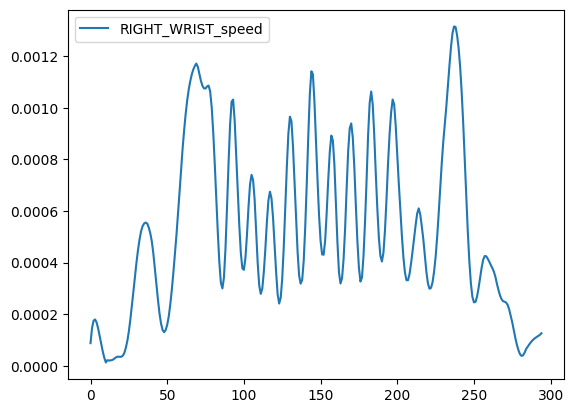

In [18]:
sample['RIGHT_WRIST_speed'].plot()
plt.legend()
plt.show()

This is speed of first derivated, then smoothed data

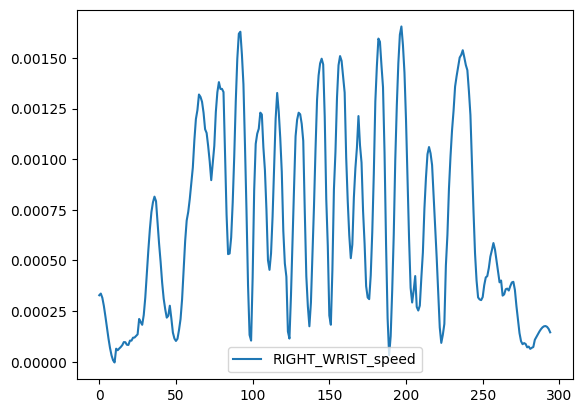

In [19]:
sample_test['RIGHT_WRIST_speed'].plot()
plt.legend()
plt.show()

Now let's look at the acceleration of the first smoothed, then derivated data

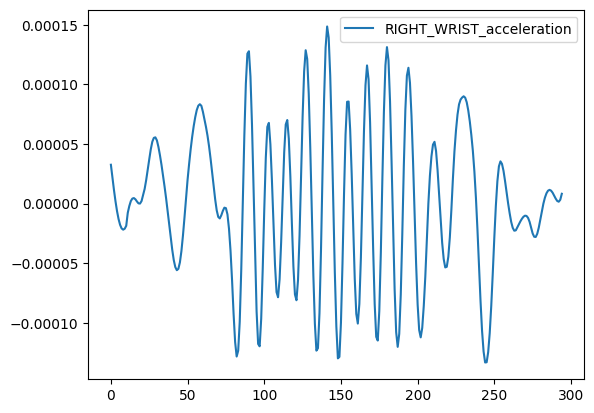

In [20]:
sample['RIGHT_WRIST_acceleration'].plot()
plt.legend()
plt.show()

And now the acceleration of the first derivated, then smoothed data

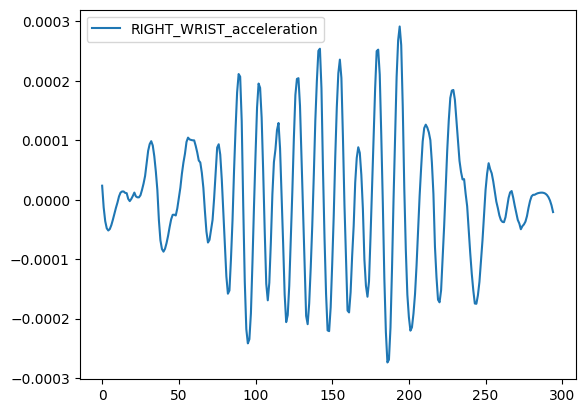

In [21]:
sample_test['RIGHT_WRIST_acceleration'].plot()
plt.legend()
plt.show()

What do you see?

- 
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-

Yes, the order matters. Differentiating multiplies the noise present in a signal, so before **every** differentiation, we want to make sure our data are *relatively* clean. 

So now we performed all steps that are necessary to get nice, clean data ready for analysis - on a **single** file. But we have more of them ready.

Luckily, because we have all the steps in functions, we can just apply them to all files in a loop.

If we now look at the sample dataframe, is there something we might be missing for future use?

In [24]:
sample.head(20)

,time,X_NOSE,Y_NOSE,Z_NOSE,X_LEFT_EYE_INNER,Y_LEFT_EYE_INNER,Z_LEFT_EYE_INNER,X_LEFT_EYE,Y_LEFT_EYE,Z_LEFT_EYE,...,RIGHT_HIP_jerk,LEFT_EYE_OUTER_jerk,RIGHT_EYE_OUTER.1_jerk,LEFT_ELBOW_jerk,RIGHT_ANKLE_jerk,LEFT_HEEL_jerk,LEFT_ANKLE_jerk,RIGHT_PINKY_jerk,LEFT_HIP_jerk,LEFT_EYE_jerk
0,0.000000,-0.027718,0.360423,-0.506539,-0.011303,0.384256,-0.502587,-0.009388,0.382687,-0.489420,...,6.371323e-08,-6.013976e-07,-5.393107e-07,-4.191551e-06,-3.057087e-06,-0.000007,-5.839146e-06,-1.682326e-06,8.097993e-08,-6.139379e-07
1,16.666667,-0.028765,0.358518,-0.511451,-0.012325,0.382545,-0.507506,-0.010356,0.380847,-0.494310,...,-8.981557e-07,-7.609536e-06,-7.527962e-06,-1.368391e-05,-1.143770e-05,-0.000018,-1.664421e-05,-8.419923e-06,-8.166852e-07,-7.657260e-06
2,33.333333,-0.029636,0.356815,-0.515665,-0.013182,0.381014,-0.511731,-0.011166,0.379206,-0.498508,...,-1.431096e-06,-1.141418e-05,-1.133125e-05,-1.804212e-05,-1.541450e-05,-0.000024,-2.169840e-05,-1.163663e-05,-1.318827e-06,-1.147769e-05
3,50.000000,-0.030345,0.355307,-0.519228,-0.013888,0.379656,-0.515308,-0.011832,0.377757,-0.502060,...,-1.630624e-06,-1.271933e-05,-1.264781e-05,-1.854378e-05,-1.605916e-05,-0.000025,-2.240369e-05,-1.220068e-05,-1.512778e-06,-1.278403e-05
4,66.666667,-0.030905,0.353984,-0.522185,-0.014454,0.378465,-0.518283,-0.012364,0.376489,-0.505012,...,-1.582617e-06,-1.215922e-05,-1.210719e-05,-1.632661e-05,-1.432822e-05,-0.000022,-2.001038e-05,-1.088546e-05,-1.477114e-06,-1.221477e-05
5,83.333333,-0.031332,0.352837,-0.524582,-0.014894,0.377432,-0.520701,-0.012777,0.375394,-0.507409,...,-1.363310e-06,-1.029829e-05,-1.026984e-05,-1.238846e-05,-1.106307e-05,-0.000017,-1.561712e-05,-8.369549e-06,-1.281652e-06,-1.033815e-05
6,100.000000,-0.031638,0.351859,-0.526467,-0.015220,0.376550,-0.522607,-0.013081,0.374464,-0.509298,...,-1.039299e-06,-7.631195e-06,-7.627129e-06,-7.587269e-06,-6.989968e-06,-0.000011,-1.017090e-05,-5.236674e-06,-9.874524e-07,-7.652090e-06
7,116.666667,-0.031838,0.351041,-0.527885,-0.015445,0.375811,-0.524048,-0.013290,0.373689,-0.510723,...,-6.675414e-07,-4.582828e-06,-4.601307e-06,-2.641086e-06,-2.720033e-06,-0.000005,-4.467045e-06,-1.975742e-06,-6.468197e-07,-4.584255e-06
8,133.333333,-0.031945,0.350374,-0.528882,-0.015582,0.375209,-0.525069,-0.013414,0.373062,-0.511731,...,-2.953518e-07,-1.508283e-06,-1.545541e-06,1.871917e-06,1.250756e-06,0.000001,8.507622e-07,1.019176e-06,-3.032997e-07,-1.492008e-06
9,150.000000,-0.031973,0.349849,-0.529505,-0.015643,0.374735,-0.525716,-0.013467,0.372573,-0.512367,...,3.959382e-08,1.307125e-06,1.256098e-06,5.513465e-06,4.541560e-06,0.000006,5.290506e-06,3.448838e-06,8.318417e-09,1.337567e-06


# Final code to process every file in Output_TimeSeries

In [26]:
import os
import glob
import pandas as pd
import numpy as np


# Get the current working directory
curfolder = os.getcwd()

# Get all the files in the folder
mtfiles = glob.glob(os.path.join(mtfolder, '*body_world.csv'))

# If the folder TS_processed does not exist, create it
processedfolder = os.path.join(curfolder, 'TS_processed')
if not os.path.exists(processedfolder):
    os.makedirs(processedfolder, exist_ok=True)

for file in mtfiles:
    fileID = os.path.basename(file).split('.')[0]

    print('working on:', fileID)

    # Load the file
    sample = pd.read_csv(file)

    # Drop visibility columns
    sample = sample.drop(sample.columns[sample.columns.str.contains('visibility', case=False)], axis=1)

    # Flip the data
    sample = flip_data(sample)

    # Interpolate the data
    sample = interpolate(sample)

    # Smooth the data
    sample = smooth_data(sample)

    # Derive speed, acceleration, jerk
    cols = sample.columns.drop(['time'])
    speedcols, sample = derive_speed_smooth(cols, sample, sr)
    sample = derive_accel_smooth(speedcols, sample)
    sample = derive_jerk_smooth(speedcols, sample)

    # Convert all columns to cms 
    cols = sample.columns
    cols = cols.drop(['time'])
    for col in cols:
        sample[col] = sample[col]*100

    # Save it
    sample.to_csv(os.path.join(processedfolder, f'{fileID}.csv'), index=False)



working on: 0_1_pr_36_p0_snijden_gebaren_video_raw_cam2
working on: 0_1_trial_34_p1_springen_combinatie_video_raw_cam2
working on: 0_1_trial_43_p0_sterk_gebaren_video_raw_cam2
working on: 0_1_trial_53_p1_vangen_gebaren_video_raw_cam2


# Next steps

Now we have clean data with all three derivatives.

> ### 🤔 What else might I need before getting to actual analysis?

- normalizing keypoints (e.g., to isolate keypoints, to control for body size, ...)
- merging with ELAN (or any other) annotation 
- alternatively, creating annotation based on some rule, i.e., anytime wrist speed is above 15 cm/s
- merging with speech data (or any other continuous data stream)


> ### 🤔 What might I need for an actual analysis?

That obviously heavily depends on the research question, but some common steps might be:

- collecting features of interest (e.g., mean speed of right wrist during certain annotated segments)
- collecting prominent timepoints (e.g., timepoints of peak speed)

```python

from scipy.signal import find_peaks

find_peaks(sample['right_wrist_speed'], height=15)

```

- comparison of time series (e.g., Dynamic Time Warping, Cross-correlation)

```python

import dtw

alignment = dtw.dtw(sample1['right_wrist_speed'], sample2['right_wrist_speed'], keep_internals=True)

```


